In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Normality of utterance length across the dataset

- Length of training samples must be above 1.6 seconds, and below 11 seconds. 
- The distribution of the length should be normal.

In [150]:
def gather_utterances(directory):
    data = []
    for speaker_dir in filter(lambda d: d.is_dir(), directory.glob('*')):
        for utterance_dir in filter(lambda d: d.is_dir(), speaker_dir.glob('*utterance')):
            for utterance_fp in utterance_dir.glob('*-alignments.json'):
                utterance_df = pd.read_json(utterance_fp)
                utterance_df['speaker'] = speaker_dir.name
                utterance_df['filename'] = str(utterance_fp.stem)
                utterance_df['duration'] = utterance_df['end_ts'].max() - utterance_df['start_ts'].min()
                
                data.append(utterance_df)
    if len(data) == 0:
        # print(f"No data in {directory}")
        return pd.DataFrame()
    df = pd.concat(data)
    return df

In [3]:
directory = Path("../data/01_interim/2018_AIM-1418")
df = gather_utterances(directory)
summary_df = df.groupby(['filename', 'speaker'], as_index=False).agg({'score': ['mean', 'max', 'min'], 'duration': lambda x: x[0]})
summary_df.columns = summary_df.columns.map('_'.join)
summary_df = summary_df.rename(columns={'duration_<lambda>': 'duration'})
summary_df.head(3)

,filename_,speaker_,score_mean,score_max,score_min,duration
0,David-Adam-10-utterance0-alignments,David-Adam,0.764420,0.999645,0.054181,10.001250
1,David-Adam-10-utterance1-alignments,David-Adam,0.747071,0.995184,0.017691,3.920500
2,David-Adam-10-utterance10-alignments,David-Adam,0.744137,0.998912,0.417033,10.901438


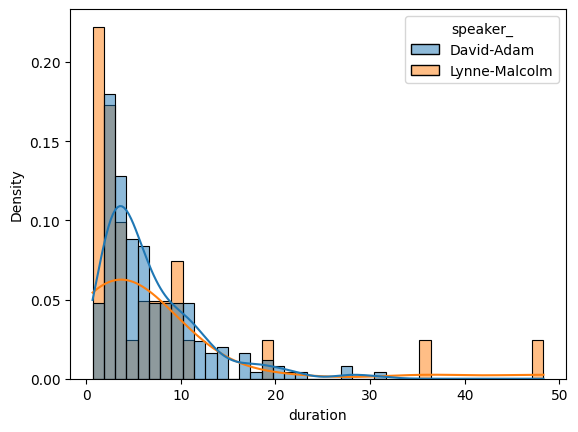

In [5]:
sns.histplot(x='duration', data=summary_df, hue="speaker_", 
             stat="density",
             common_norm=False,
             bins=40,
             kde=True)

plt.show()

Quite a few samples are too long and need to be further split. Since the splitting algorithm chooses boundaries between utterances as the position of high-scored words, this can lead to very long utterances if diarization is poor.

In [151]:
directorys = [p for p in Path("../data/01_interim").glob('*') if not p.name.startswith('o')]
datas=[]
summaries=[]
for directory in directorys:
    df = gather_utterances(directory)
    if df.shape[0] == 0:
        continue
    datas.append(df)
    summary_df = df.groupby(['filename', 'speaker'], as_index=False).agg({'score': ['mean', 'max', 'min'], 'duration': lambda x: x[0]})
    summary_df.columns = summary_df.columns.map('_'.join)
    summary_df = summary_df.rename(columns={'duration_<lambda>': 'duration', 'speaker_': 'speaker'})
    summaries.append(summary_df)
df = pd.concat(datas)
summaries_df = pd.concat(summaries)

## Distribution of sample length across Speakers

Most of the Speakers don't have normally distributed sample length. The Model might struggle to synthesize speech of different lengths.

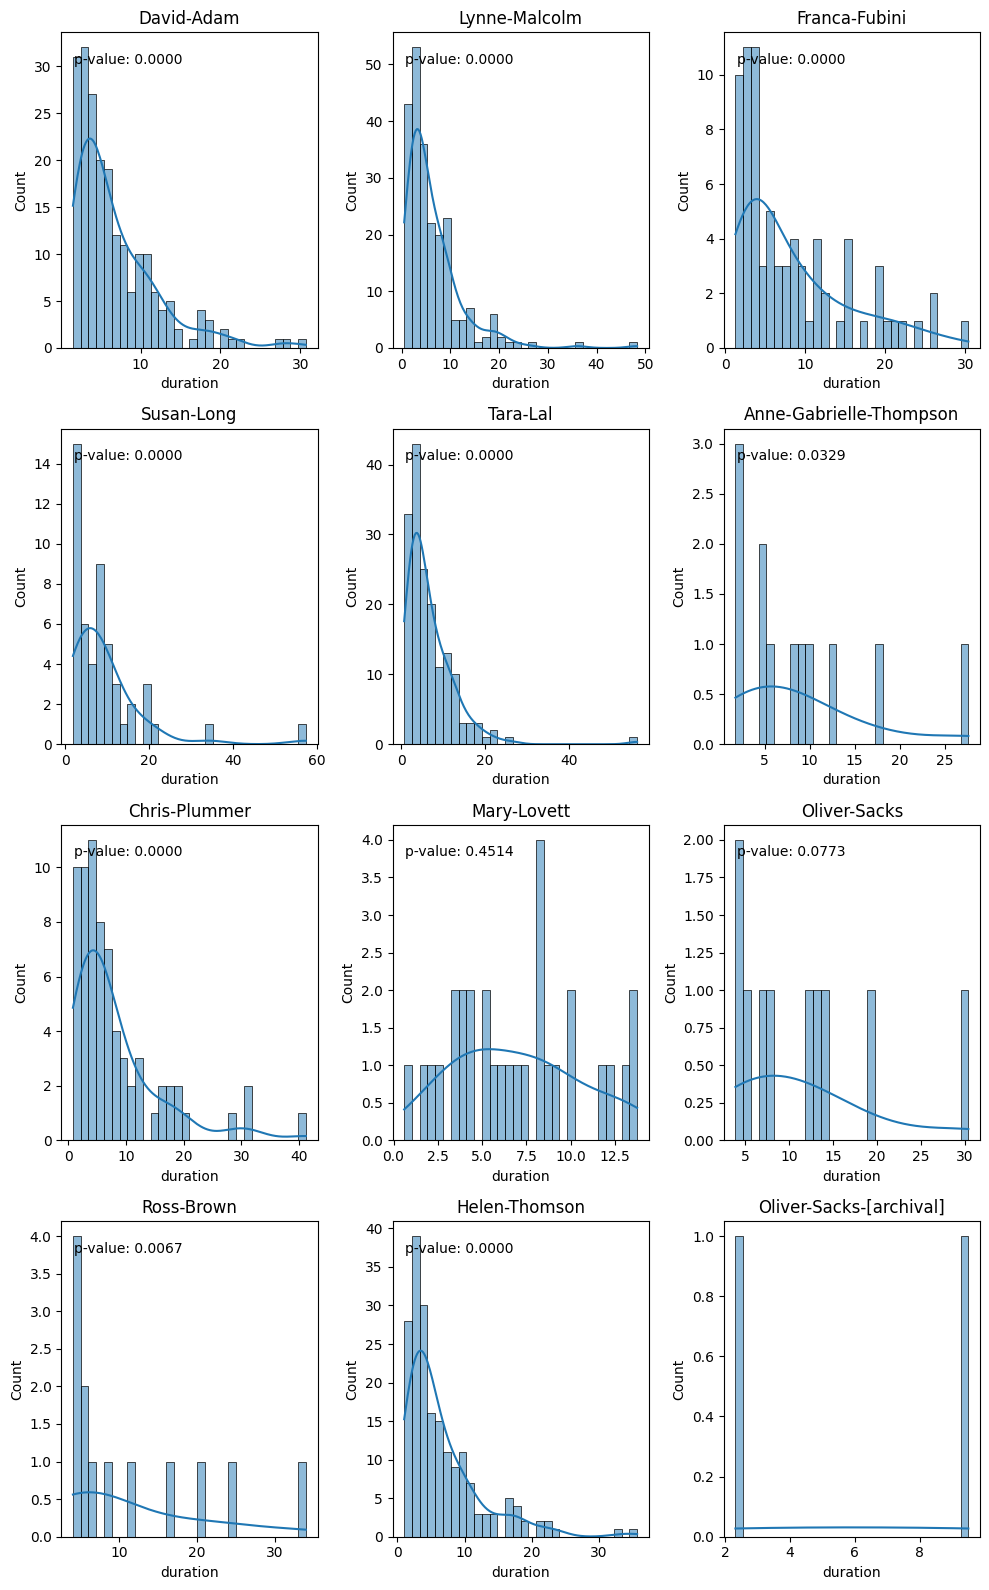

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Get the number of unique speakers
num_speakers = summaries_df['speaker'].nunique()

# Calculate the number of rows and columns based on the number of speakers
num_cols = 3
num_rows = num_speakers // num_cols + num_speakers % num_cols

# Create the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 4))

# Iterate over the unique speakers and plot the histograms
for i, speaker in enumerate(summaries_df['speaker'].unique()):
    speaker_data = summaries_df[summaries_df['speaker'] == speaker]
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data=speaker_data, 
                 x='duration', 
                 ax=axes[row, col], 
                 bins=30,
                 kde=True)
    axes[row, col].set_title(speaker)

    # Calculate the Shapiro-Wilk test statistic
    if speaker_data.shape[0] < 3:
        continue
    _, p_value = shapiro(speaker_data['duration'])

    # Annotate the plot with the p-value
    axes[row, col].text(0.1, 0.9, f'p-value: {p_value:.3f}', transform=axes[row, col].transAxes)

# Remove empty axes if necessary
if num_speakers % 2 != 0:
    axes[-1, -1].remove()

plt.tight_layout()
plt.show()

## Balance of phenome distribution per Speaker

The Synthesizer and Voice encoder learn to produce sequence data (mel-spectograms and then waveforms), from the transcript. First it's tokenized by converting words into phonemes.

In [1]:
sentence = "BOOST BRAIN POWER FIRST HE TRIED SMART PILLS THEN HE MOVED ON TO ELECTRICAL BRAIN STIMULATION FOR COGNITIVE ENHANCEMENT"
print(sentence)

BOOST BRAIN POWER FIRST HE TRIED SMART PILLS THEN HE MOVED ON TO ELECTRICAL BRAIN STIMULATION FOR COGNITIVE ENHANCEMENT


Extract phenomes from words

In [34]:
from big_phoney import BigPhoney
from collections import Counter, defaultdict

phoney = BigPhoney()

speaker_phenomes = defaultdict(list)
for idx, row in df.iterrows():
    speaker_phenomes[row.speaker].append(row.label)

ignored_words = []
speaker_counts = dict()
for speaker, text in speaker_phenomes.items():
    phonemes = []
    for word in text:
        if phoney.phonetic_dict.lookup(word) is not None:
            phonemes.extend(phoney.phonize(word).split(' '))
        else:
            ignored_words.append(word)
    speaker_counts[speaker] = Counter(phonemes)

Gather phenome distribution per speaker, from the training data.

In [87]:
sentence_phonemes = []
sentence_words = sentence.split(' ')
for word in sentence_words:
    if phoney.phonetic_dict.lookup(word) is not None:
        sentence_phonemes.append(phoney.phonize(word).split(' '))
    else:
        sentence_phonemes.append(None)
        
for speaker in speaker_counts:
    speaker_counts[speaker].keys()

Visualise the distribution of phenomes per-speaker. This gives indication if one speaker's training data was unbalanced.

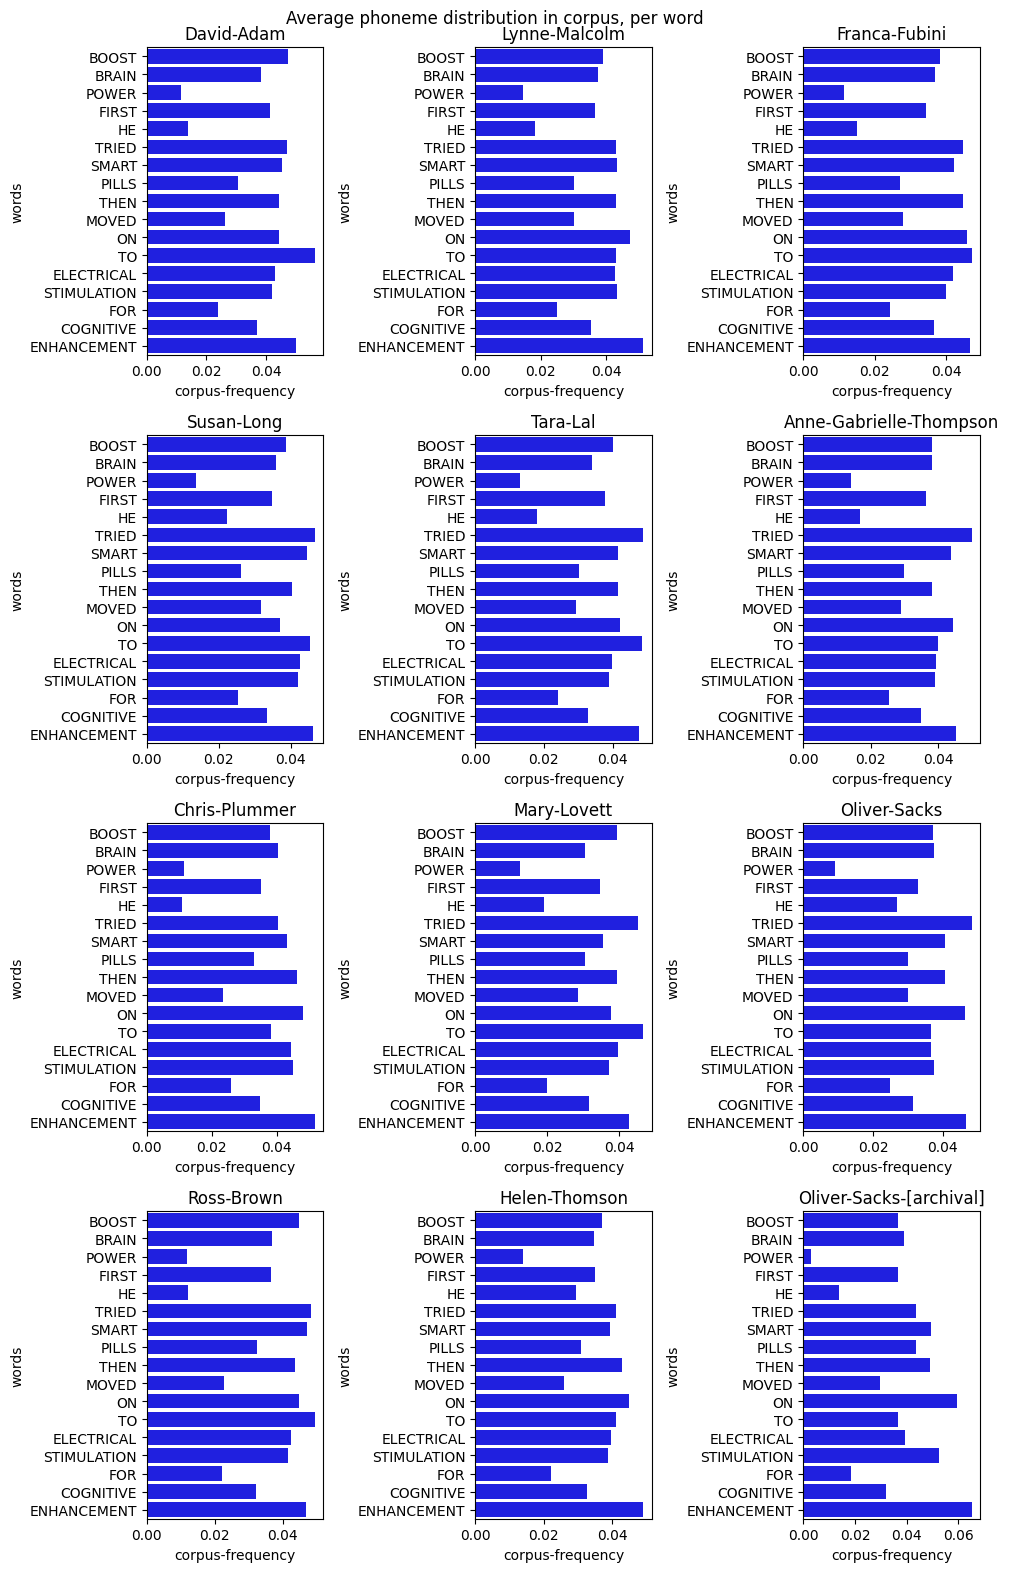

In [155]:
# Get the number of unique speakers
num_speakers = summaries_df['speaker'].nunique()

# Calculate the number of rows and columns based on the number of speakers
num_cols = 3
num_rows = num_speakers // num_cols + num_speakers % num_cols

# Create the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 4))

# Iterate over the unique speakers and plot the histograms
for i, speaker in enumerate(summaries_df['speaker'].unique()):
    tot_obs = sum(speaker_counts[speaker].values())
    speaker_data = {ph: val / tot_obs for ph, val in speaker_counts[speaker].items()}

    occurances = pd.DataFrame([0]*len(sentence_phonemes), 
                                columns=['corpus-frequency'], 
                                index=pd.Series(sentence_words, name='words'))
    for wrd_i, word_phenomes in enumerate(sentence_phonemes):
        occurances.loc[sentence_words[wrd_i], 'corpus-frequency'] = sum([speaker_data.get(ph, 0) for ph in word_phenomes]) / len(word_phenomes)
    occurances['words'] = occurances.index
    
    row = i // num_cols
    col = i % num_cols
    sns.barplot(data=occurances, 
                x='corpus-frequency', 
                y='words',
                ax=axes[row, col], 
                color='b')
    axes[row, col].set_title(speaker)

# Remove empty axes if necessary
if num_speakers % 2 != 0:
    axes[-1, -1].remove()

plt.suptitle("Average phoneme distribution in corpus, per word")
plt.tight_layout()
plt.show()
